https://github.com/openai/CLIP

In [ ]:
!pip install ftfy regex tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oxdjb4i7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-oxdjb4i7
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=678b50e951e16219f7707a95e7ed43b0772059b722ff36de14e4d99e0d8d482e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6tm1vc6m/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
!nvidia-smi

Wed Sep 14 06:18:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle
!kaggle datasets download -d julymarc/agrocode-data-science-cup-2022
!unzip -qq /content/agrocode-data-science-cup-2022.zip

!mkdir weights
!mkdir data
!mkdir data/test
!mkdir data/queries

100% 205M/205M [00:01<00:00, 148MB/s]
100% 205M/205M [00:01<00:00, 137MB/s]


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil

In [ ]:
train = pd.read_csv('train.csv')
test = train.sample(frac=0.04, random_state=41)
test.to_csv('./data/test.csv', index=False)
queries = train.sample(frac=0.04, random_state=42)
queries = queries[['idx']]
queries.to_csv('./data/queries.csv')

for idx in test['idx'].values:
    shutil.copy(f'./train/train/{idx}.png', './data/test')
for idx in queries['idx'].values:
    shutil.copy(f'./train/train/{idx}.png', './data/queries')

CLIP

In [ ]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
!ls ~/.cache/clip/ViT-B-32.pt

ls: cannot access '/root/.cache/clip/ViT-B-32.pt': No such file or directory


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

if os.path.exists('./weights/ViT-B-32.pt'):
  model, preprocess = clip.load("./weights/ViT-B-32.pt", device=device)
else:
  model, preprocess = clip.load("ViT-B/32", device=device)
  shutil.copy('/root/.cache/clip/ViT-B-32.pt', './weights')

image = preprocess(Image.open("/content/data/test/1006.png")).unsqueeze(0).to(device)
# text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    # text_features = model.encode_text(text)
    
    # logits_per_image, logits_per_text = model(image, text)
    # probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
torch.squeeze(image_features).shape

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 197MiB/s]


torch.Size([512])

Zero-shot Prediction

In [ ]:
# import os
# import clip
# import torch
# from torchvision.datasets import CIFAR100

# # Load the model
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load('ViT-B/32', device)

# # Download the dataset
# cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# # Prepare the inputs
# image, class_id = cifar100[3637]
# image_input = preprocess(image).unsqueeze(0).to(device)
# text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# # Calculate features
# with torch.no_grad():
#     image_features = model.encode_image(image_input)
#     text_features = model.encode_text(text_inputs)

# # Pick the top 5 most similar labels for the image
# image_features /= image_features.norm(dim=-1, keepdim=True)
# text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# values, indices = similarity[0].topk(5)

# # Print the result
# print("\nTop predictions:\n")
# for value, index in zip(values, indices):
#     print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

Linear-probe evaluation

In [ ]:
# import os
# import clip
# import torch

# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from torch.utils.data import DataLoader
# from torchvision.datasets import CIFAR100
# from tqdm import tqdm

# # Load the model
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load('ViT-B/32', device)

# # Load the dataset
# root = os.path.expanduser("~/.cache")
# train = CIFAR100(root, download=True, train=True, transform=preprocess)
# test = CIFAR100(root, download=True, train=False, transform=preprocess)


# def get_features(dataset):
#     all_features = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
#             features = model.encode_image(images.to(device))

#             all_features.append(features)
#             all_labels.append(labels)

#     return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# # Calculate the image features
# train_features, train_labels = get_features(train)
# test_features, test_labels = get_features(test)

# # Perform logistic regression
# classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
# classifier.fit(train_features, train_labels)

# # Evaluate using the logistic regression classifier
# predictions = classifier.predict(test_features)
# accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
# print(f"Accuracy = {accuracy:.3f}")

Inference

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

import torch
import clip
from PIL import Image


queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')


device = "cuda" if torch.cuda.is_available() else "cpu"

if os.path.exists('./weights/ViT-B-32.pt'):
  model, preprocess = clip.load("./weights/ViT-B-32.pt", device=device)
else:
  model, preprocess = clip.load("ViT-B/32", device=device)
  shutil.copy('/root/.cache/clip/ViT-B-32.pt', './weights')


def extract_features(path, model=model):

    image = preprocess(Image.open(path)).unsqueeze(0).to(device)

    with torch.no_grad():
      image_features = model.encode_image(image)
    
    feature = torch.squeeze(image_features).cpu().numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
pred_data = pred_data.drop(pred_data[pred_data.database_idx == pred_data.query_idx].index)

In [ ]:
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
7262,1.000000,1867
6296,1.000000,972
6212,1.000000,6727
5182,1.000000,1867
259,1.000000,1867
...,...,...
2979,0.759364,1592
4671,0.755539,1955
2343,0.744350,1886


In [ ]:
idx_f = 2979
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
460,0.759364,1592,2979
461,0.758992,5606,2979
462,0.737713,4268,2979
463,0.734194,2999,2979
464,0.730695,1565,2979
465,0.717981,3120,2979
466,0.706287,679,2979
467,0.705501,2869,2979
468,0.702521,1251,2979
469,0.695551,4038,2979


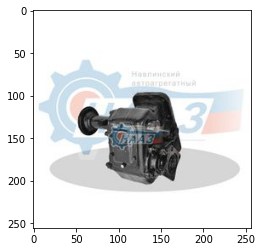

candidates:
score: [0.75936359]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


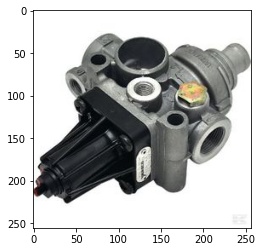

score: [0.75899237]


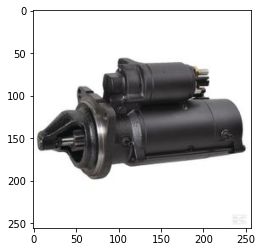

score: [0.73771277]


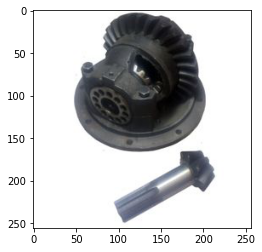

score: [0.73419422]


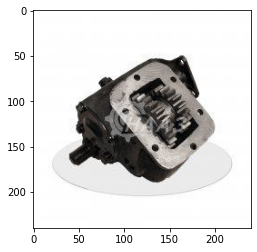

score: [0.73069534]


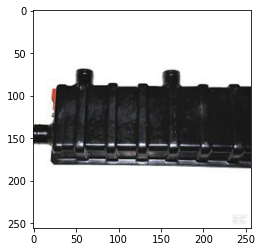

score: [0.7179809]


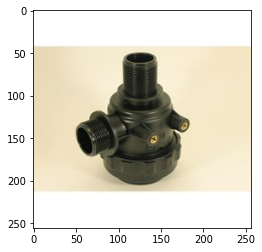

score: [0.70628727]


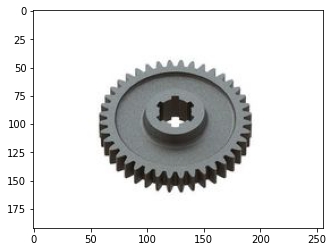

score: [0.7055013]


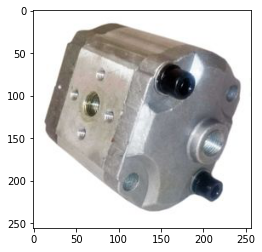

score: [0.70252082]


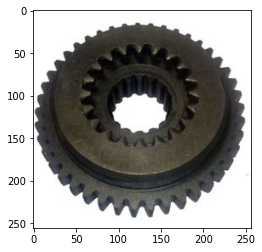

score: [0.69555051]


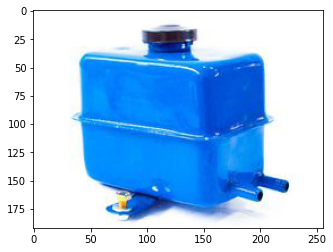

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = f'./train/train/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'./train/train/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()